# Import and data loading

By doing basic visualization of our dataset, we can see that there are some outliers in the age category, with a value around 400. Our first cleaning step is to remove rows with implausible ages.

In [1]:
import os
from glob import glob
import io
from itertools import chain
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import pyarrow as pa
import pyarrow.parquet as pq
import warnings
import copy
warnings.filterwarnings("ignore", category=FutureWarning)

### Load dataset and visualize classes
DATA_FILE_PATH = "../input/data/Data_Entry_2017.csv"
BASE_IMAGE_DIR = "/kaggle/input/data"

full_df = pd.read_csv(DATA_FILE_PATH)
full_df = full_df[full_df['Patient Age'] <= 100]
full_df.describe()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


# Data visualization
We first look at the classes and notice there is a major class imbalance. 
For our labels of choice, there are roughly 4000 pictures of interest with some class imbalance. 

Since other disease like cardiomegaly, effusion, etc. are associated with heart failure we explored disease interdependencies to see if there are highly correlated features that we could use to further improve our model. 

None of the coefficient were particularly high except for the combination of both targets. While there are some differences between both targets, taking into account conditional probabilities in our model would increase its complexity greatly with what would probably be a limited improvement in accuracy.

No Finding            60353
Infiltration          19891
Effusion              13316
Atelectasis           11558
Nodule                 6331
Mass                   5779
Pneumothorax           5301
Consolidation          4667
Pleural_Thickening     3384
Cardiomegaly           2776
Emphysema              2516
Edema                  2302
Fibrosis               1686
Pneumonia              1430
Hernia                  227
Name: count, dtype: int64


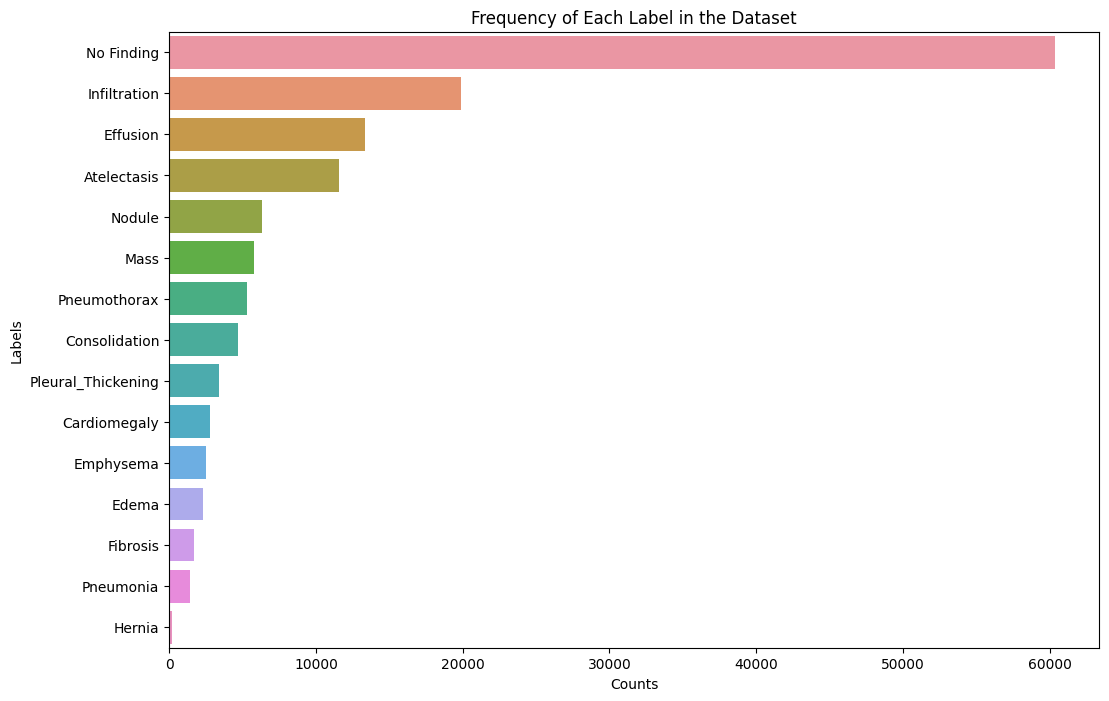

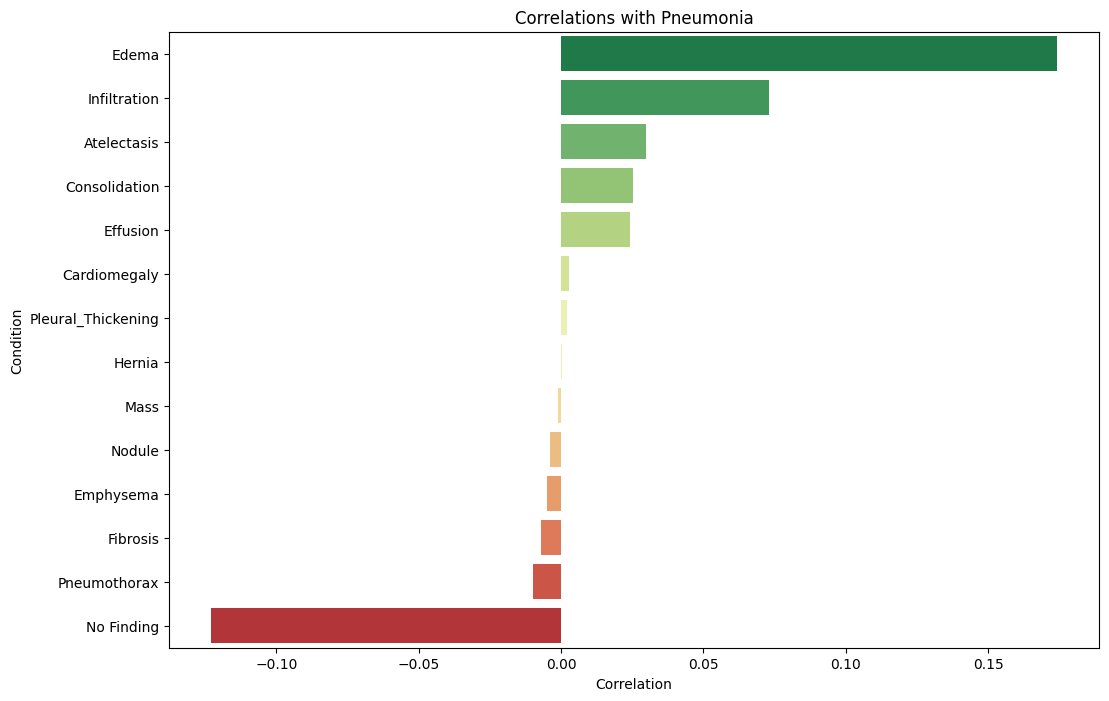

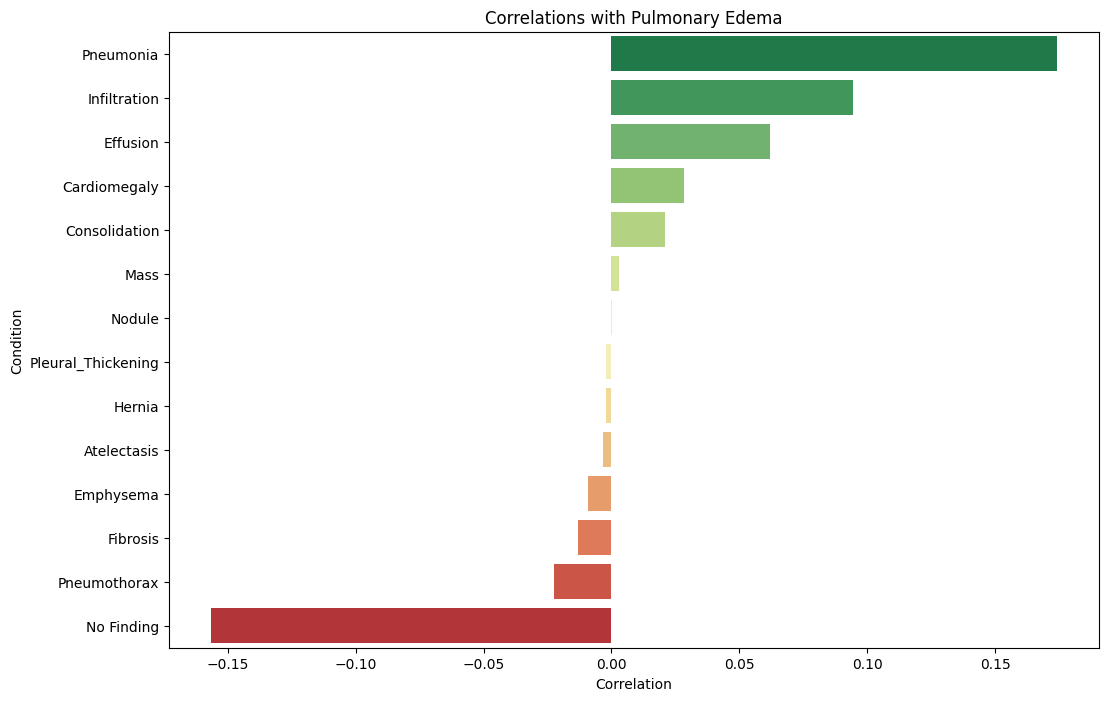

In [2]:
all_labels = np.unique(list(chain(*full_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

for c_label in all_labels:
    if len(c_label) > 0:
        full_df[c_label] = full_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

label_counts = (
    full_df["Finding Labels"].str.split("|", expand=True).stack().value_counts()
)
print(label_counts)
label_columns = [label for label in all_labels if label in full_df.columns]
label_df = full_df[label_columns]

correlation_matrix = label_df.corr()

# 1. Overall Label Counts
plt.figure(figsize=(12, 8))
sns.barplot(y=label_counts.index, x=label_counts.values)
plt.title("Frequency of Each Label in the Dataset")
plt.xlabel("Counts")
plt.ylabel("Labels")
plt.show()

# Calculate correlations for Pneumonia and Edema
correlations_pneumonia = {label: correlation_matrix.at[label, 'Pneumonia'] for label in label_columns if 'Pneumonia' in label_columns}
correlations_edema = {label: correlation_matrix.at[label, 'Edema'] for label in label_columns if 'Edema' in label_columns}

# Visualize correlations with Pneumonia
correlation_df_pneumonia = pd.DataFrame.from_dict(correlations_pneumonia, orient='index', columns=['Correlation']).drop(['Pneumonia'])
correlation_df_pneumonia = correlation_df_pneumonia.reset_index().rename(columns={'index': 'Condition'})
correlation_df_pneumonia = correlation_df_pneumonia.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_df_pneumonia['Correlation'], y=correlation_df_pneumonia['Condition'], palette="RdYlGn_r")
plt.title("Correlations with Pneumonia")
plt.xlabel("Correlation")
plt.ylabel("Condition")
plt.show()

# Visualize correlations with Edema
correlation_df_edema = pd.DataFrame.from_dict(correlations_edema, orient='index', columns=['Correlation']).drop(['Edema'])
correlation_df_edema = correlation_df_edema.reset_index().rename(columns={'index': 'Condition'})
correlation_df_edema = correlation_df_edema.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_df_edema['Correlation'], y=correlation_df_edema['Condition'], palette="RdYlGn_r")
plt.title("Correlations with Pulmonary Edema")
plt.xlabel("Correlation")
plt.ylabel("Condition")
plt.show()

# Target labelling
For our problem, we are interested in differentiating between pulmonary edema and pneumonia, since its a relevant clinical problem we often face in the hospital. 

Multiple approaches can be taken, we could for instance use two models using a one vs rest approach to learn to detect pneumonia, learn to detect edema and combine both models predictions. 

In our case, we chose to go with a multilabel classification algorithm, which will be more straightforward to implement. Even though the combination of pneumonia and edema is a rare occurence in this dataset, in real life it is not uncommon, so we choose clinically meaningful classes. Thus, we want our model to perform a supervised learning classification between 5 classes : "Pneumonia", "Edema", "Both", "Normal" and "Other" to represent the other heterogeneous classes of disease. 

To handle class imbalance, we massively undersampled the "Normal" and "Other" categories that included most of the dataset, and oversampled the "Both" category.

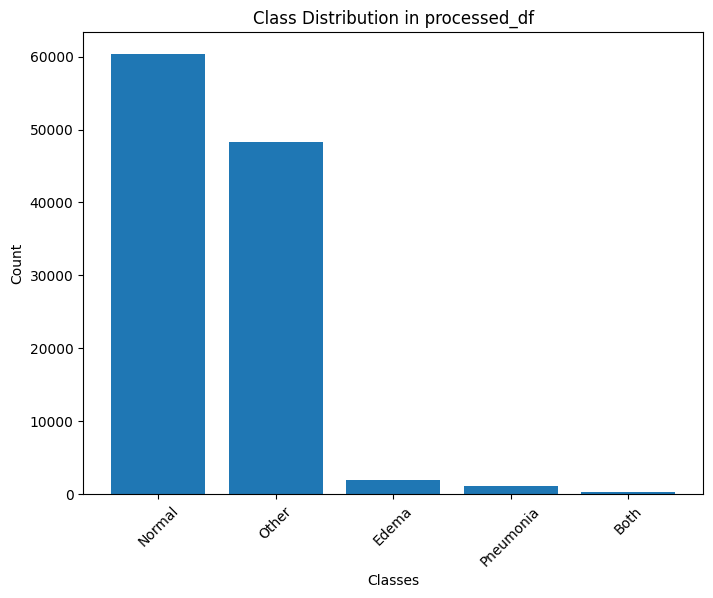

In [3]:
def processing(df, label_col, conditions, undersample_size=2000):
    """
    Categorizes labels, undersamples 'Normal' and 'Other' classes.
    """
    def categorize_label(label):
        if conditions[0] in label and conditions[1] in label:
            return "Both"
        elif conditions[0] in label:
            return "Pneumonia"
        elif conditions[1] in label:
            return "Edema"
        elif "No Finding" in label:
            return "Normal"
        else:
            return "Other"

    df["Target"] = df[label_col].apply(categorize_label)  
    return df

processed_df = processing(full_df, "Finding Labels", ["Pneumonia", "Edema"])
classes = processed_df["Target"].unique().tolist()

class_counts = processed_df["Target"].value_counts()

# Classes in final dataset
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Distribution in processed_df")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

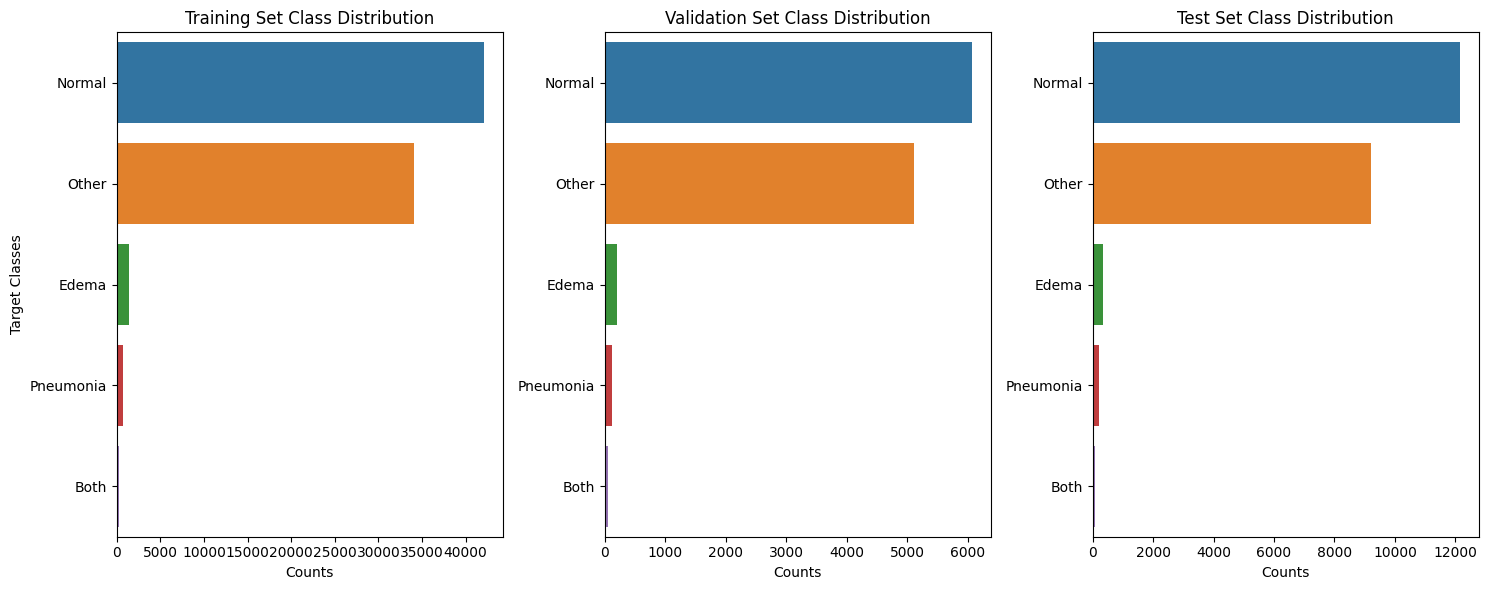

In [4]:
# Unique patient identifier
patient_col = "Patient ID"

test_size = 0.2
valid_size = 0.1

# Create a GroupShuffleSplit instance
gss = GroupShuffleSplit(n_splits=1, test_size=test_size + valid_size, random_state=50)

# Split the dataset
for train_idx, test_valid_idx in gss.split(processed_df, groups=processed_df[patient_col]):
    train_df = processed_df.iloc[train_idx]
    test_valid_df = processed_df.iloc[test_valid_idx]

# Further split the test_valid_df into validation and test sets
gss_valid = GroupShuffleSplit(
    n_splits=1, test_size=test_size / (test_size + valid_size), random_state=42
)

for valid_idx, test_idx in gss_valid.split(
    test_valid_df, groups=test_valid_df[patient_col]
):
    valid_df = test_valid_df.iloc[valid_idx]
    test_df = test_valid_df.iloc[test_idx]
    
def plot_class_distributions(dataframes, titles):
    """
    Plots the class distributions of multiple DataFrames side by side.
    """
    plt.figure(figsize=(15, 6))

    # Total number of DataFrames
    num_dfs = len(dataframes)

    for i, df in enumerate(dataframes):
        plt.subplot(1, num_dfs, i+1)
        class_counts = df['Target'].value_counts()
        sns.barplot(x=class_counts.values, y=class_counts.index)
        plt.title(titles[i])
        plt.xlabel('Counts')
        if i == 0:
            plt.ylabel('Target Classes')
        else:
            plt.ylabel('')

    plt.tight_layout()
    plt.show()

# Call the function with your datasets
plot_class_distributions(
    [train_df, valid_df, test_df], 
    ['Training Set Class Distribution', 'Validation Set Class Distribution', 'Test Set Class Distribution']
)


In [5]:
train_df_disease = train_df[train_df['Target'].isin(["Edema", "Pneumonia", "Both"])]
val_df_disease = valid_df[valid_df['Target'].isin(["Edema", "Pneumonia", "Both"])]
test_df_disease = test_df[test_df['Target'].isin(["Edema", "Pneumonia", "Both"])]

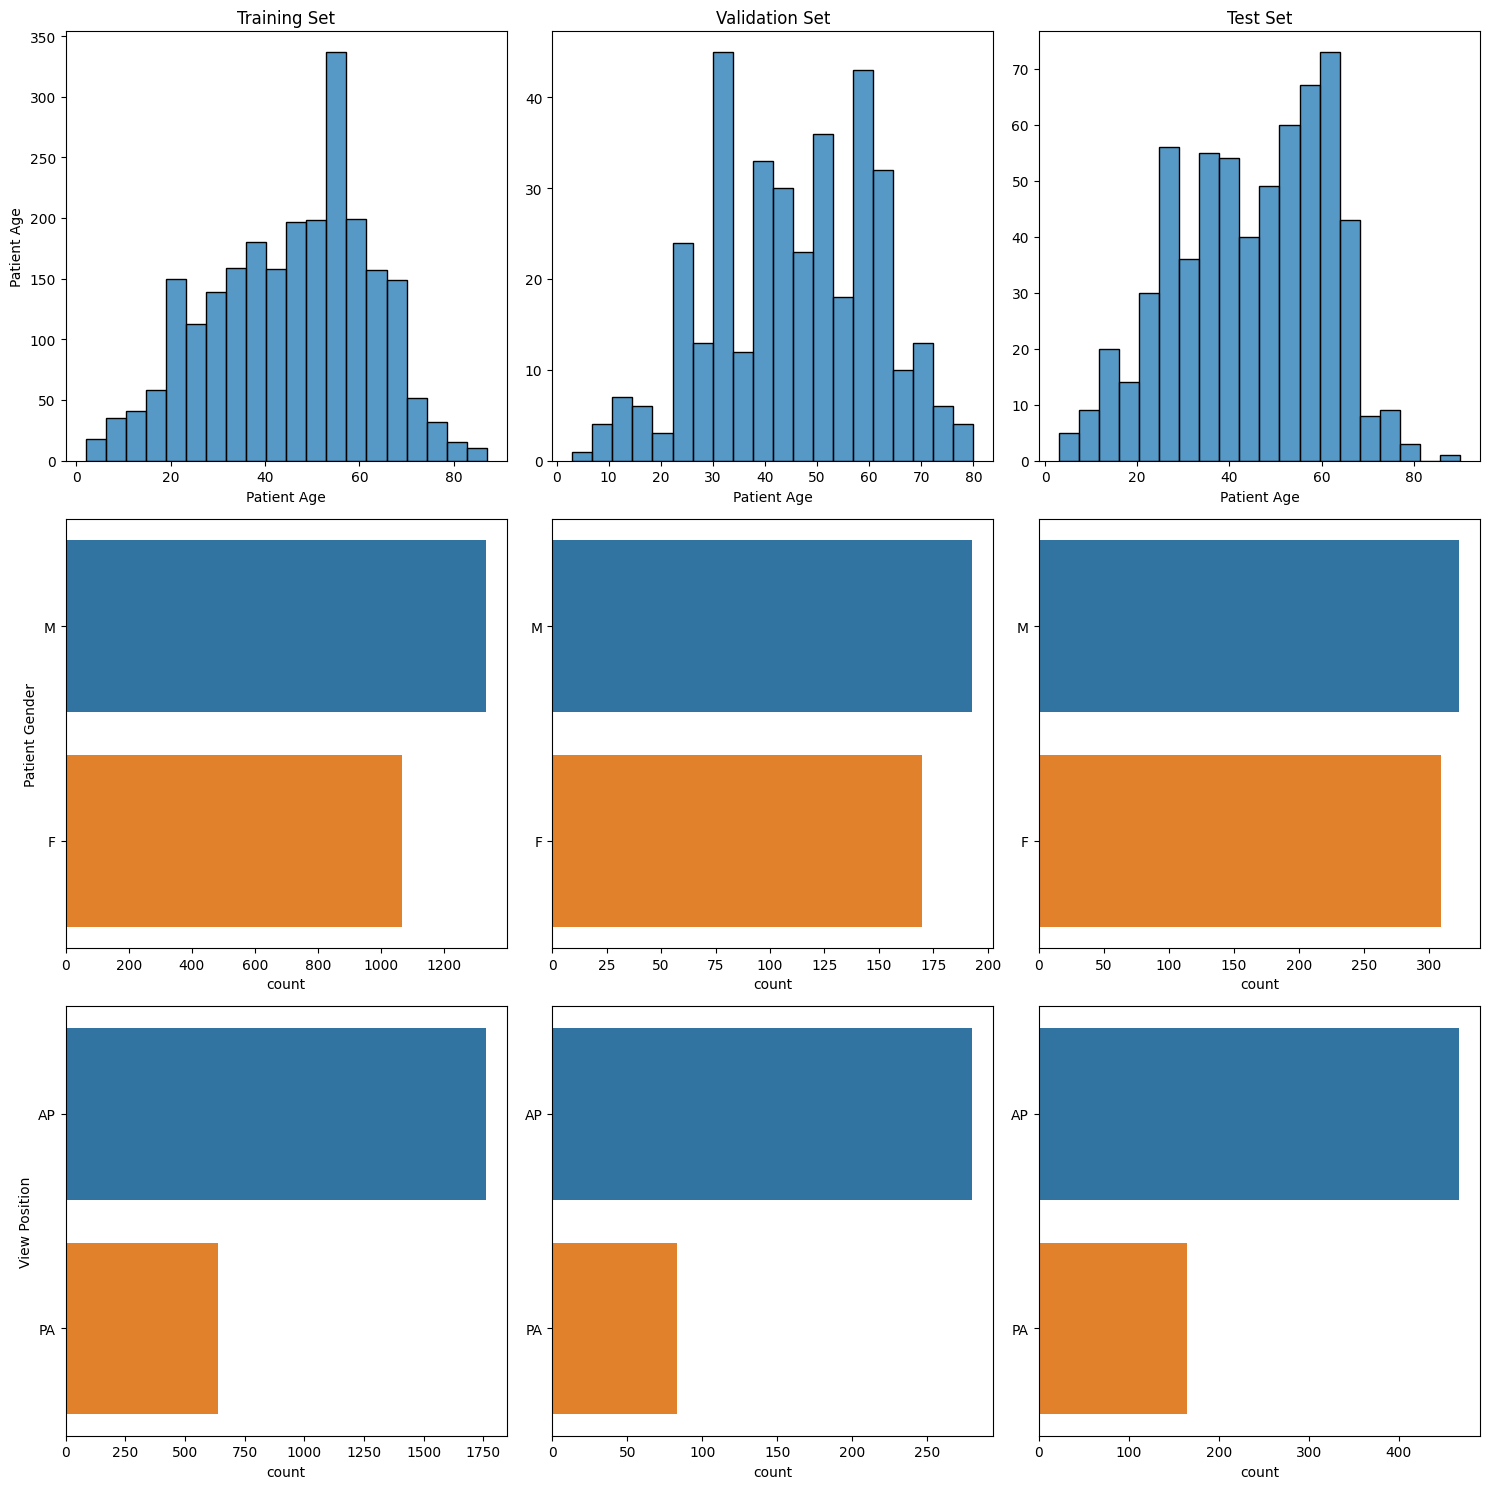

In [8]:
def plot_distributions(dataframes, titles, columns):
    """
    Plots the distributions of specified columns for multiple DataFrames.
    """
    num_dfs = len(dataframes)
    num_cols = len(columns)

    plt.figure(figsize=(15, 5 * num_cols))

    for i, df in enumerate(dataframes):
        for j, col in enumerate(columns):
            plt.subplot(num_cols, num_dfs, num_dfs * j + i + 1)
            if df[col].dtype == 'object':
                sns.countplot(y=df[col], order = df[col].value_counts().index)
            else:
                sns.histplot(df[col], bins=20, kde=False)
            
            if j == 0:
                plt.title(titles[i])
            
            if i == 0:
                plt.ylabel(col)
            else:
                plt.ylabel('')

    plt.tight_layout()
    plt.show()

# Specify the columns you want to plot
columns_to_plot = ['Patient Age', 'Patient Gender', 'View Position']

# Call the function with your datasets
plot_distributions(
    [train_df_disease, val_df_disease, test_df_disease], 
    ['Training Set', 'Validation Set', 'Test Set'],
    columns_to_plot
)

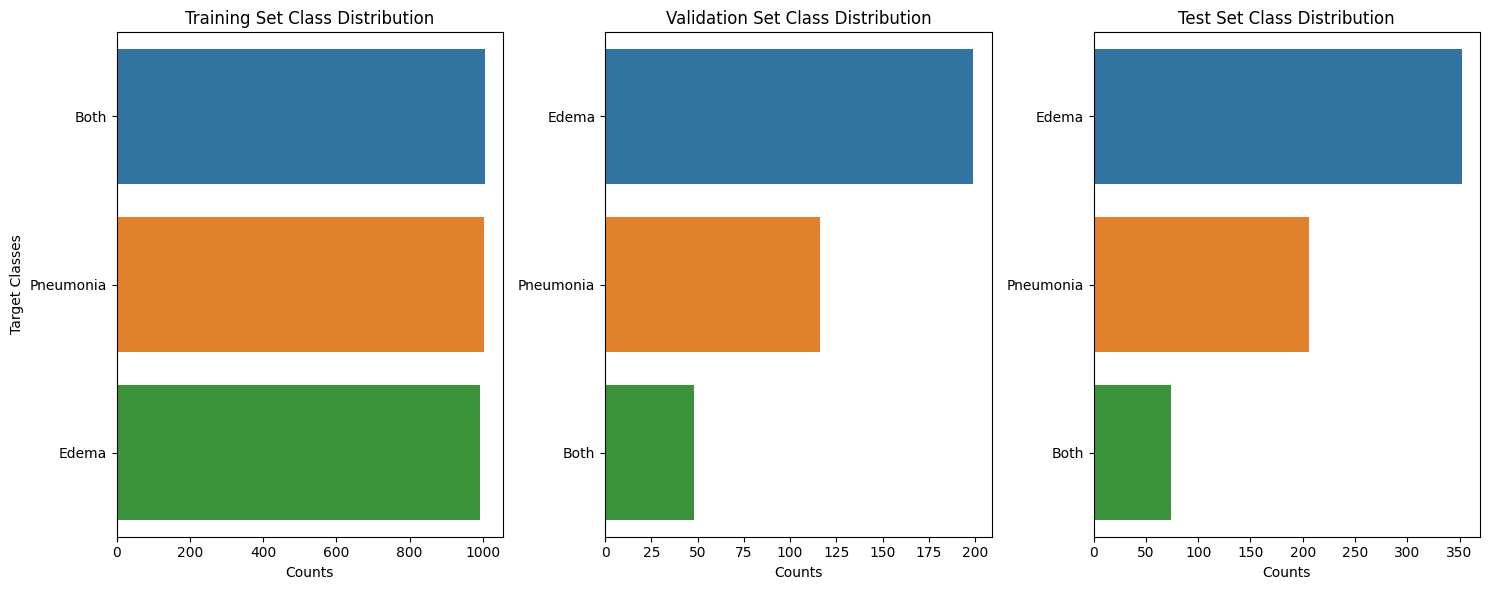

In [9]:
def create_inverse_weighted_sample(df, target_column, sample_size):
    # Calculate class weights (inverse of class frequencies)
    class_counts = df[target_column].value_counts()
    total_samples = df.shape[0]
    class_weights = {cls: total_samples/count for cls, count in class_counts.items()}

    # Assign a weight to each row in the DataFrame
    weights = df[target_column].map(class_weights)

    # Perform weighted random sampling
    return df.sample(n=sample_size, weights=weights, replace=True)

equalized_train_df_disease = create_inverse_weighted_sample(train_df_disease, 'Target', sample_size=3000)
plot_class_distributions(
    [equalized_train_df_disease, val_df_disease, test_df_disease], 
    ['Training Set Class Distribution', 'Validation Set Class Distribution', 'Test Set Class Distribution'])

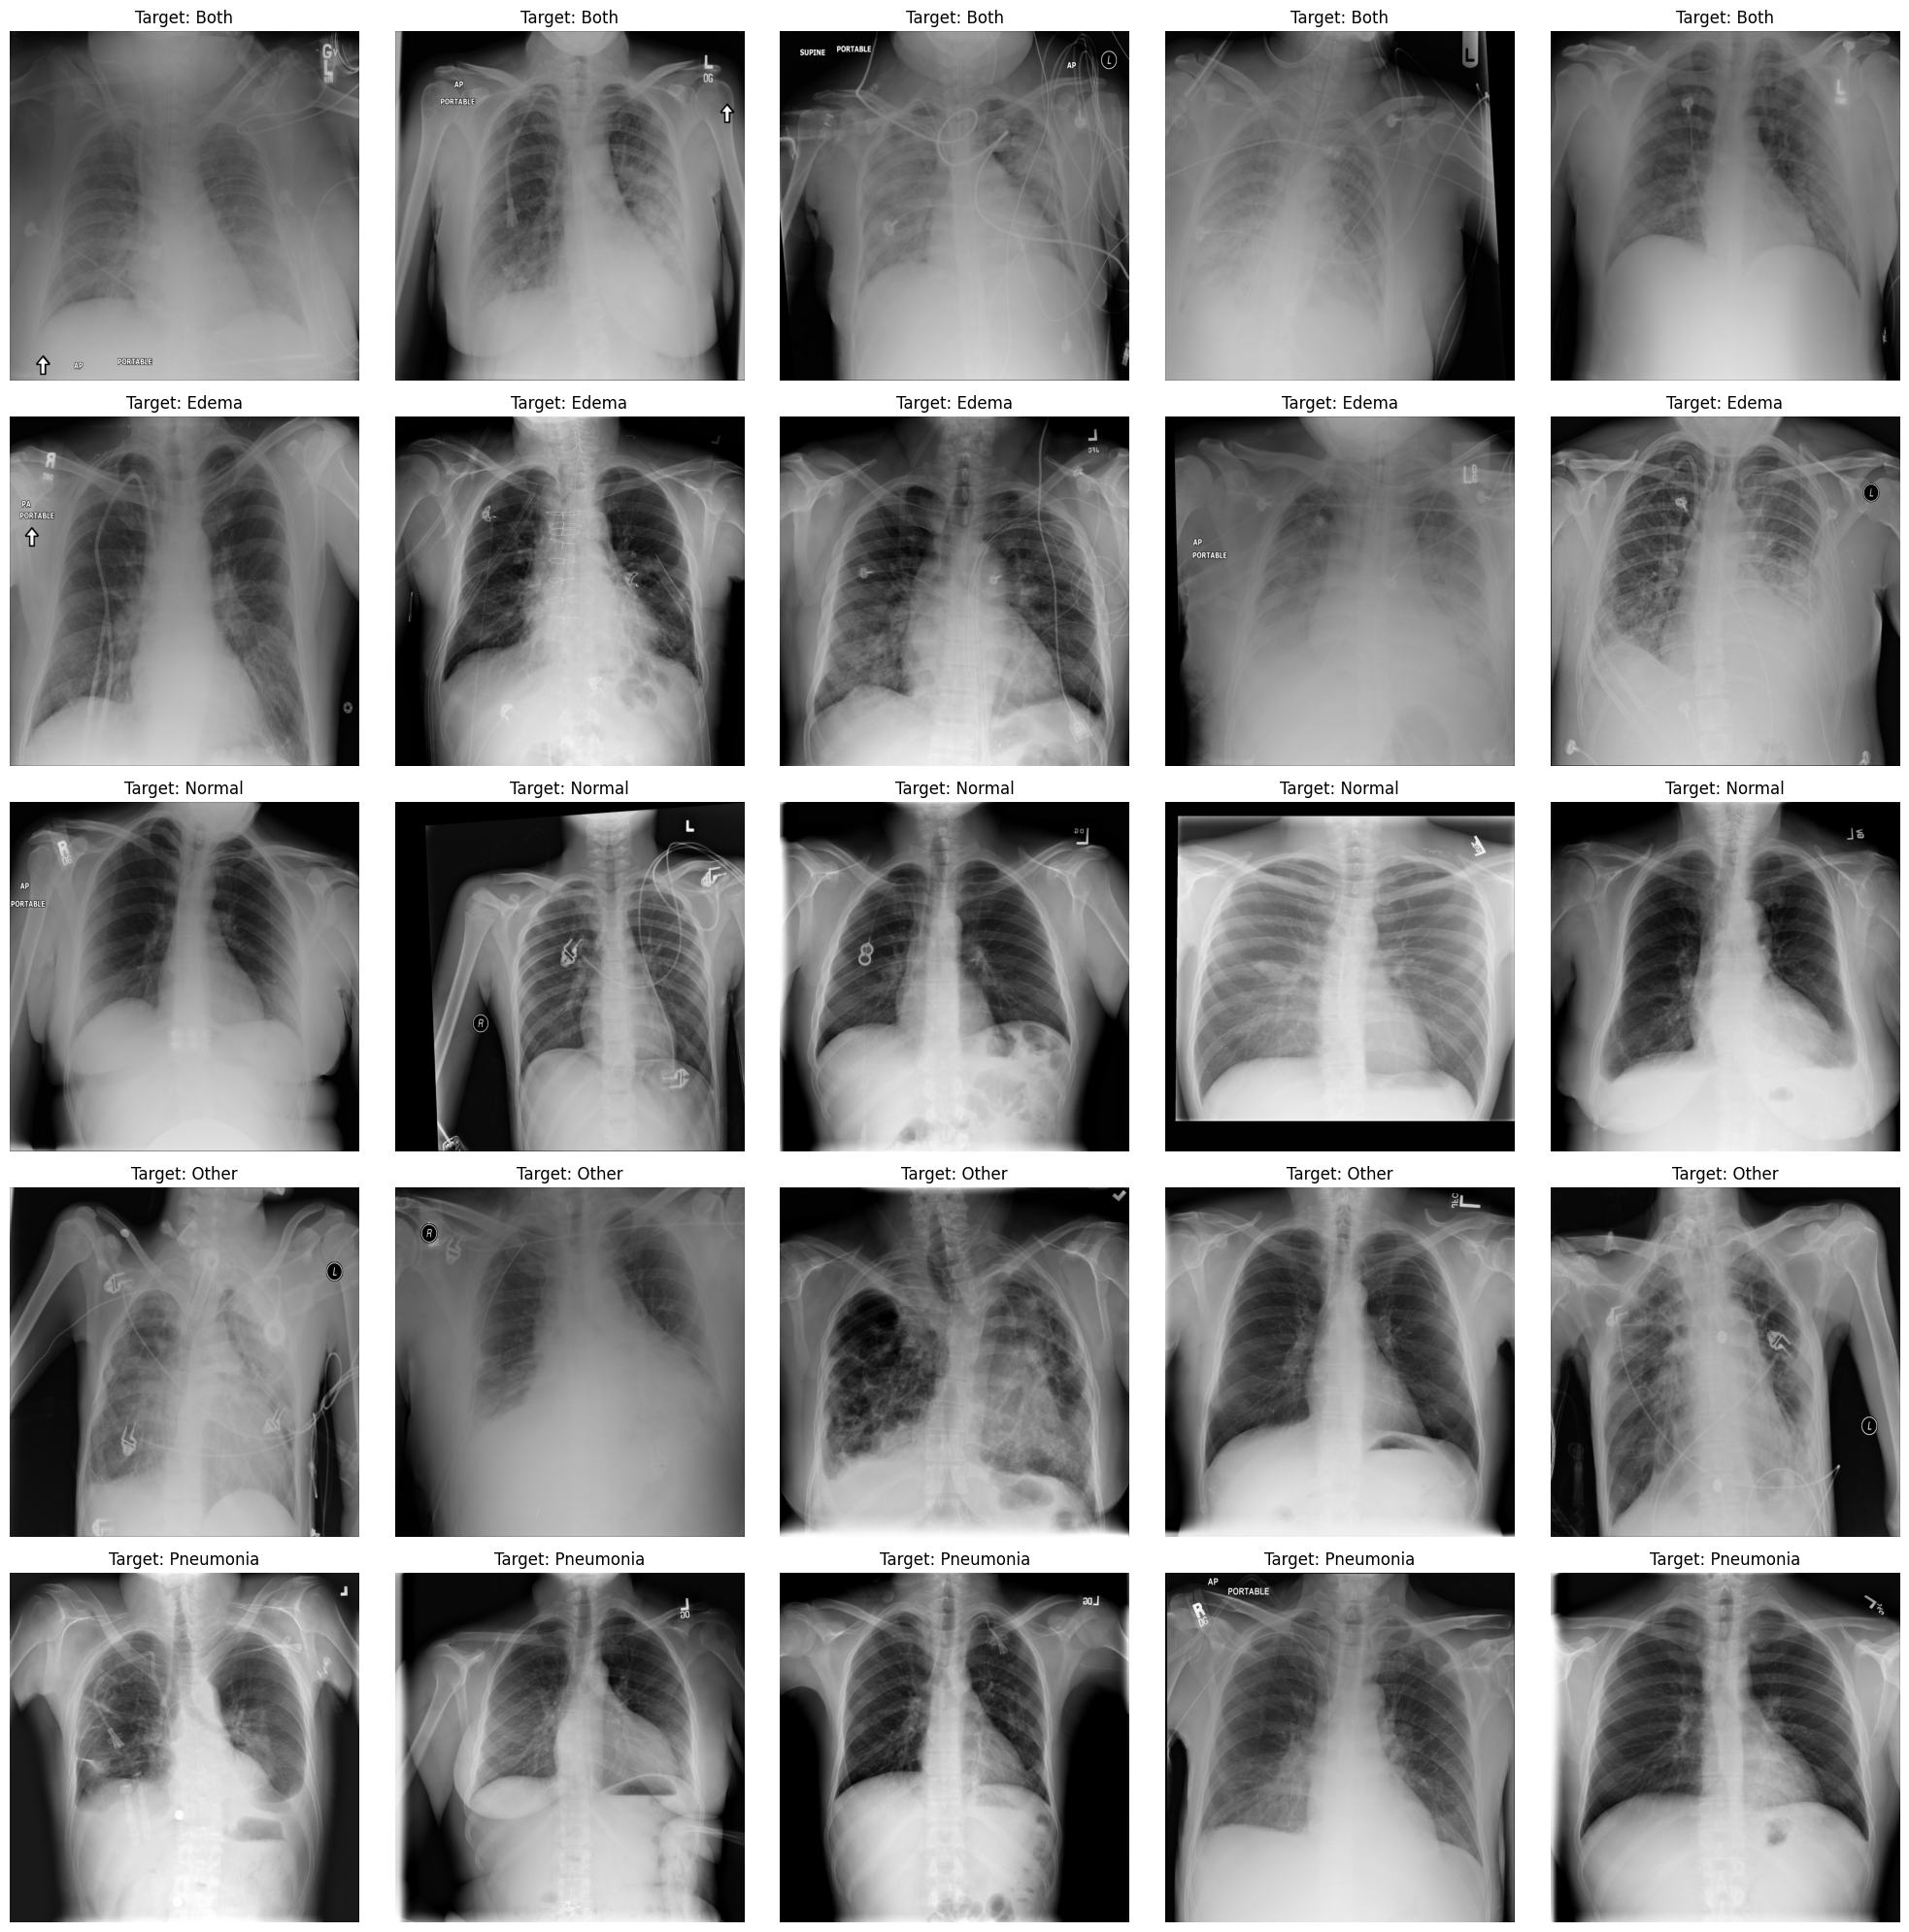

In [10]:
base_image_dir = "/kaggle/input/data"

# Build the dictionary
image_folder_path = {
    os.path.basename(x): x
    for x in glob(os.path.join(base_image_dir, "images*", "images", "*.png"))
}

# Define a function to load and transform images
def load_transform_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

# Define a function to save images and labels to a Parquet file
def save_images_to_parquet(dataset, filename):
    table = pa.Table.from_pandas(dataset)
    pq.write_table(table, filename)
    
# Define the transforms for each dataset
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomCrop((224, 224)),  
    transforms.RandomRotation(5),  
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])    
    
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
])

# Function to process and save dataset
def process_and_save_dataset(df, image_paths_dict, transform, filename):
    images = []
    labels = []
    image_names = [] 

    for _, row in df.iterrows():
        img_path = image_paths_dict.get(row['Image Index'])
        if img_path:
            image = load_transform_image(img_path, transform)
            image_np = np.array(image)
            image_bytes = image_np.tobytes()
            images.append(image_bytes)
            labels.append(row['Target'])
            image_names.append(row['Image Index'])  

    dataset = pd.DataFrame({
        'image_names': image_names,
        'images': images,
        'labels': labels
    })

    save_images_to_parquet(dataset, filename)
    
def plot_images(df, image_paths_dict, figsize=(20, 20)):

    grouped = df.groupby('Target')
    fig, axs = plt.subplots(len(grouped), 5, figsize=figsize)  # 5 columns for each target

    for i, (target, group) in enumerate(grouped):
        random_samples = group.sample(n=5, replace=False)  # Select 5 random samples per target
        for j in range(5):
            img_name = random_samples.iloc[j]['Image Index']
            img_path = image_paths_dict.get(img_name)
            if img_path:
                image = Image.open(img_path).convert("RGB")
                image = np.asarray(image)
                axs[i, j].imshow(image)
                axs[i, j].set_title(f"Target: {target}")
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images(processed_df, image_folder_path)


In [11]:
process_and_save_dataset(equalized_train_df_disease, image_folder_path, train_transform, "train_images_disease.parquet")
process_and_save_dataset(val_df_disease, image_folder_path, val_test_transform, "val_images_disease.parquet")
process_and_save_dataset(test_df_disease, image_folder_path, val_test_transform, "test_images_disease.parquet")

equalized_train_df_disease.to_parquet("train_df_disease.parquet", index=False)
val_df_disease.to_parquet("valid_df_disease.parquet", index=False)
test_df_disease.to_parquet("test_df_disease.parquet", index=False)

In [13]:
# Show characteristics of image before binary encoding, will be used when loading the parquet files
image_np = load_transform_image("/kaggle/input/data/images_001/images/00000001_000.png", val_test_transform)  

image_shape = image_np.shape  
image_dtype = image_np.dtype  

print("Image Shape:", image_shape)
print("Data Type:", image_dtype)

Image Shape: torch.Size([3, 224, 224])
Data Type: torch.float32


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings

Epoch 1/10, Loss: 1.8326
Epoch 2/10, Loss: 1.7620
Epoch 3/10, Loss: 1.7332
Epoch 4/10, Loss: 1.6912
Epoch 5/10, Loss: 1.6680
Epoch 6/10, Loss: 1.6652
Epoch 7/10, Loss: 1.6147
Epoch 8/10, Loss: 1.6099
Epoch 9/10, Loss: 1.5966
Epoch 10/10, Loss: 1.5626
Test Loss: 1.6660


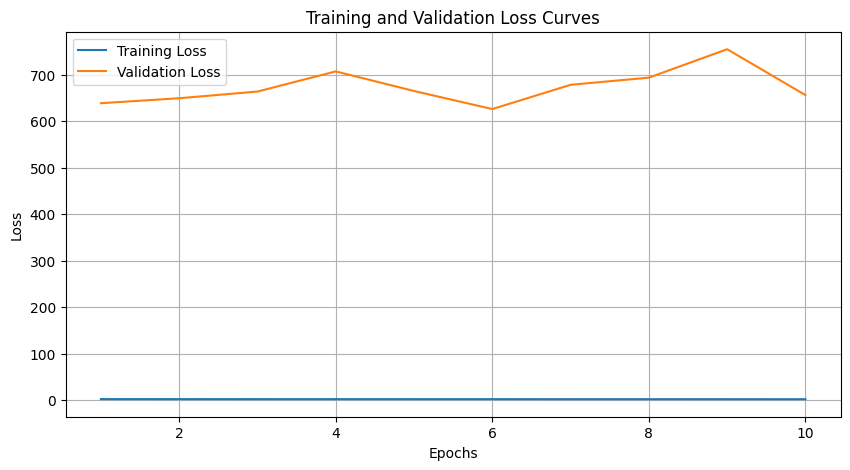

Classification Report:
               precision    recall  f1-score   support

        Both       0.20      0.20      0.20        74
       Edema       0.66      0.66      0.66       352
   Pneumonia       0.59      0.58      0.59       206

    accuracy                           0.58       632
   macro avg       0.48      0.48      0.48       632
weighted avg       0.58      0.58      0.58       632



In [4]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import copy

# Change the number of classes to select the proper parquet files
num_class = 3
if num_class == 3 :
    df_path = "/kaggle/input/pulmonary-edema-and-pneumonia-nih/train_df_disease.parquet"

elif num_class == 5 :
    df_path = "/kaggle/input/images-and-sets-nih-xray/train_df.parquet"
else : 
    raise exception 

def prepare_dataset(df_path):
    train_df = pd.read_parquet(df_path)
    label_encoder = LabelEncoder()
    label_encoder.fit(train_df["Target"])
    class_to_idx = {cls: idx for idx, cls in enumerate(label_encoder.classes_)}
    target_counts = train_df["Target"].value_counts()
    num_samples = len(train_df)
    class_weights = {c: num_samples / count for c, count in target_counts.items()}
    return class_to_idx, class_weights

class_to_idx, class_weights = prepare_dataset(df_path)

class ParquetImageDataset(Dataset):
    def __init__(self, parquet_filename, class_to_idx, transform=None):
        self.parquet_table = pq.read_table(parquet_filename).to_pandas()
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.parquet_table)

    def __getitem__(self, idx):
        row = self.parquet_table.iloc[idx]
        image_bytes = np.frombuffer(row['images'], dtype=np.float32)
        image = torch.tensor(image_bytes.reshape(3, 224, 224)).to(torch.float32)
        if self.transform:
            image = self.transform(image)
        label_idx = self.class_to_idx[row['labels']]
        label = torch.zeros(len(self.class_to_idx))
        label[label_idx] = 1
        return image, label
    
if num_class == 3 :
    train_dataset = ParquetImageDataset("/kaggle/input/pulmonary-edema-and-pneumonia-nih/train_images_disease.parquet", class_to_idx)
    valid_dataset = ParquetImageDataset("/kaggle/input/pulmonary-edema-and-pneumonia-nih/val_images_disease.parquet", class_to_idx)
    test_dataset = ParquetImageDataset("/kaggle/input/pulmonary-edema-and-pneumonia-nih/test_images_disease.parquet", class_to_idx)

elif num_class == 5 :
    train_dataset = ParquetImageDataset("/kaggle/input/images-and-sets-nih-xray/train_images.parquet", class_to_idx)
    valid_dataset = ParquetImageDataset("/kaggle/input/images-and-sets-nih-xray/val_images.parquet", class_to_idx)
    test_dataset = ParquetImageDataset("/kaggle/input/images-and-sets-nih-xray/test_images.parquet", class_to_idx)
else : 
    raise exception 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Your custom ResNet18 model definition
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

class ParquetImageDataset(Dataset):
    def __init__(self, parquet_filename, class_to_idx, transform=None):
        self.parquet_table = pq.read_table(parquet_filename).to_pandas()
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.parquet_table)

    def __getitem__(self, idx):
        row = self.parquet_table.iloc[idx]
        image_bytes = np.frombuffer(row['images'], dtype=np.float32)
        image = torch.tensor(image_bytes.reshape(3, 224, 224)).to(torch.float32)
        if self.transform:
            image = self.transform(image)
        label_idx = self.class_to_idx[row['labels']]
        label = torch.zeros(len(self.class_to_idx))
        label[label_idx] = 1
        return image, label
    
if num_class == 3 :
    train_dataset = ParquetImageDataset("/kaggle/input/pulmonary-edema-and-pneumonia-nih/train_images_disease.parquet", class_to_idx)
    valid_dataset = ParquetImageDataset("/kaggle/input/pulmonary-edema-and-pneumonia-nih/val_images_disease.parquet", class_to_idx)
    test_dataset = ParquetImageDataset("/kaggle/input/pulmonary-edema-and-pneumonia-nih/test_images_disease.parquet", class_to_idx)

elif num_class == 5 :
    train_dataset = ParquetImageDataset("/kaggle/input/images-and-sets-nih-xray/train_images.parquet", class_to_idx)
    valid_dataset = ParquetImageDataset("/kaggle/input/images-and-sets-nih-xray/val_images.parquet", class_to_idx)
    test_dataset = ParquetImageDataset("/kaggle/input/images-and-sets-nih-xray/test_images.parquet", class_to_idx)
else : 
    raise exception 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Use your custom ResNet18 model
model = CustomResNet18(num_classes=num_class)

# Check if GPU is available and use it if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define weighted loss
criterion = nn.BCEWithLogitsLoss(weight=torch.FloatTensor(list(class_weights.values())).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=5):
    best_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    train_losses = []
    valid_losses = []

    model.to(device)  # Move the model to the device

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)

        valid_losses.append(valid_loss)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    # After training
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses

num_epochs = 10

# Call the function
model, train_losses, valid_losses = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs=num_epochs
)

model.eval()
test_loss = 0.0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(torch.argmax(labels, 1).cpu().numpy())

print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")

# Save the best model
torch.save(model.state_dict(), "best_model.pth")

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(np.arange(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.grid(True)
plt.show()

# Function to get predictions
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(labels, 1).cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions for the test dataset
test_preds, test_labels = get_predictions(model, test_loader)

# Generate a classification report
report = classification_report(test_labels, test_preds, target_names=list(class_to_idx.keys()))
print("Classification Report:\n", report)